In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt

In [2]:
# Load the data
df = pd.read_csv('data_co2.csv', names=['Year', 'PPM'], skiprows=1)

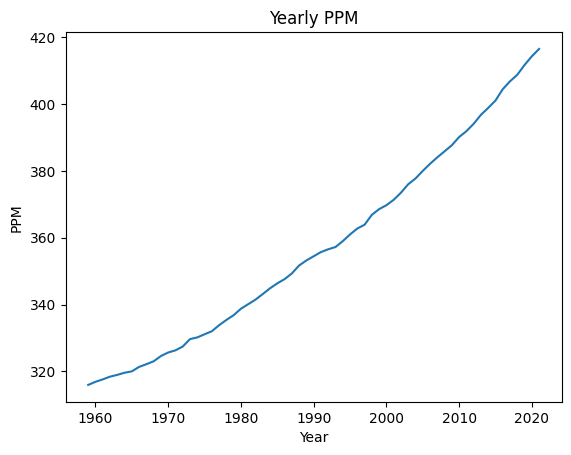

In [3]:
plt.plot(df['Year'], df['PPM'])
plt.xlabel('Year')
plt.ylabel('PPM')
plt.title('Yearly PPM')
plt.show()

In [4]:
df.drop('Year', axis=1, inplace=True)
data = df.values


def normalize(data, min, max):
    return (data - min) / (max - min)


data_normed = normalize(data, data.min(axis=0), data.max(axis=0))
data_normed[:10]

array([[0.        ],
       [0.00925649],
       [0.01652234],
       [0.02458445],
       [0.02995919],
       [0.03622972],
       [0.04041007],
       [0.05364786],
       [0.06170996],
       [0.07036926]])

In [5]:
split = int(0.8 * len(data_normed))
train, val = data_normed[:split], data_normed[split:]


def windowed_dataset(series, batch_size, n_past=10, n_future=10, shift=1):
    '''
    :param series: an iterable
    :param batch_size: number of samples per batch
    :param n_past: number of timesteps to look back (x or input to the model)
    :param n_future: number of timesteps to predict (y or output of the model)
    :param shift: number of timesteps to shift the window by, usually 1 if we want to maximise the use of data
    :return:
    '''
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_future], w[n_future:]))  # taking the past as x, future as y, split by n_past
    ds.shuffle(8192)
    return ds.batch(batch_size).prefetch(1)


batch_size = 32  # explore how changing this affects the model (it is not as simple as larger batch size = better performance, lik ein image tasks)
n_past = 5
n_future = 5
shift = 1

train_ds = windowed_dataset(train, batch_size, n_past, n_future, shift)
valid_ds = windowed_dataset(val, batch_size, n_past, n_future, shift)

In [6]:
val

array([[0.71324774],
       [0.73773266],
       [0.75515079],
       [0.77714741],
       [0.80382204],
       [0.8244252 ],
       [0.84632229],
       [0.88016323],
       [0.9035533 ],
       [0.92306161],
       [0.95232408],
       [0.97800338],
       [1.        ]])

In [29]:
xIn = tf.keras.layers.Input(shape=(n_past,
                                   1))  # 20 input, where first dimension is the number of timesteps to look back, 2nd dimension is the number of features
x = tf.keras.layers.LSTM(32, return_sequences=True)(xIn)  # LSTM layer with 32 hidden units. Return
x = tf.keras.layers.LSTM(32)(x)
xOut = tf.keras.layers.Dense(n_future)(x)
model = tf.keras.Model(inputs=xIn, outputs=xOut)
model.compile(loss='mse', optimizer='adam', metrics='mse')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 1)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 32)             4352      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 12,837
Trainable params: 12,837
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(train_ds, epochs=100, validation_data=valid_ds)

Epoch 1/100
2/2 [==============================] - 7s 1s/step - loss: 0.1424 - mse: 0.1424 - val_loss: 0.8476 - val_mse: 0.8476
Epoch 2/100
2/2 [==============================] - 0s 53ms/step - loss: 0.1353 - mse: 0.1353 - val_loss: 0.8196 - val_mse: 0.8196
Epoch 3/100
2/2 [==============================] - 0s 58ms/step - loss: 0.1288 - mse: 0.1288 - val_loss: 0.7922 - val_mse: 0.7922
Epoch 4/100
2/2 [==============================] - 0s 50ms/step - loss: 0.1224 - mse: 0.1224 - val_loss: 0.7648 - val_mse: 0.7648
Epoch 5/100
2/2 [==============================] - 0s 51ms/step - loss: 0.1161 - mse: 0.1161 - val_loss: 0.7368 - val_mse: 0.7368
Epoch 6/100
2/2 [==============================] - 0s 52ms/step - loss: 0.1097 - mse: 0.1097 - val_loss: 0.7074 - val_mse: 0.7074
Epoch 7/100
2/2 [==============================] - 0s 60ms/step - loss: 0.1030 - mse: 0.1030 - val_loss: 0.6760 - val_mse: 0.6760
Epoch 8/100
2/2 [==============================] - 0s 54ms/step - loss: 0.0960 - mse: 0.0960

In [31]:
preds = model.predict(valid_ds)
preds[0]

1/1 [==============================] - 1s 1s/step


array([0.8760243 , 0.95127904, 0.92459995, 0.97731155, 1.0065626 ],
      dtype=float32)

In [32]:
def unnormalize(data, min, max):
    return data * (max - min) + min


preds_unnormed = unnormalize(preds, data.min(axis=0), data.max(axis=0))
preds_unnormed[0]

array([403.99416201, 411.55500557, 408.87455653, 414.17049159,
       417.10934348])

In [33]:
print(preds_unnormed.shape)
print(preds_unnormed[:, 0])
print(preds_unnormed[:, 0].shape)

(4, 5)
[403.99416201 406.71941085 409.31456599 412.18558039]
(4,)


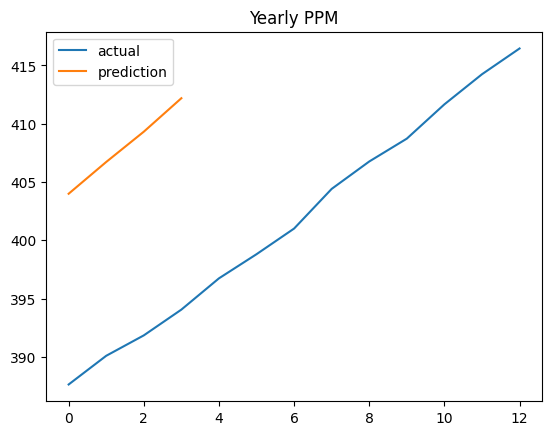

In [34]:
plt.plot(unnormalize(val, data.min(axis=0), data.max(axis=0)),
         label='actual')  # our val was taken as subset of the normaized data so we need to unnormalize it here
plt.plot(preds_unnormed[:, 0], label='prediction')
plt.legend()
plt.title('Yearly PPM')
plt.show()